In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, median_absolute_error, mean_absolute_error
from xgboost import XGBRegressor

In [3]:
# DATA CLEANING


# Load the dataset
dataset = pd.read_csv('data/AB_NYC_2019.csv')

# Drop unwanted columns
dataset.drop('id', axis=1, inplace=True)
dataset.drop('name', axis=1, inplace=True)
dataset.drop('host_id', axis=1, inplace=True)
dataset.drop('host_name', axis=1, inplace=True)
dataset.drop('number_of_reviews', axis=1, inplace=True)
dataset.drop('last_review', axis=1, inplace=True)
dataset.drop('reviews_per_month', axis=1, inplace=True)
dataset.drop('latitude', axis=1, inplace=True)
dataset.drop('longitude', axis=1, inplace=True)

# Remove price = 0
dataset = dataset[dataset.price > 0].copy()

# Standardize ratio attributes
dataset[['minimum_nights', 'calculated_host_listings_count', 'availability_365']] = StandardScaler().fit_transform(dataset[['minimum_nights', 'calculated_host_listings_count', 'availability_365']])

# Log price
dataset['log_price'] = np.log1p(dataset['price'])


# One hot encoding for the categorical features
neighbourhood_group_dummies = pd.get_dummies(dataset['neighbourhood_group'], prefix="is_group")
neighbourhood_dummies = pd.get_dummies(dataset['neighbourhood'], prefix="is_neighbourhood")
preprocessed_dataset = pd.concat([dataset[['minimum_nights','calculated_host_listings_count',
       'availability_365', 'room_type']], neighbourhood_group_dummies, neighbourhood_dummies, dataset[['price', 'log_price']]], axis=1)

# Dataset division by room type: ['Private room' 'Entire home/apt' 'Shared room']
datasets = {}
datasets['private'] = preprocessed_dataset[preprocessed_dataset.room_type == 'Private room'].copy().drop('room_type', axis=1)[preprocessed_dataset.price < 150].copy()
datasets['entire'] = preprocessed_dataset[preprocessed_dataset.room_type == 'Entire home/apt'].copy().drop('room_type', axis=1)[preprocessed_dataset.price < 380].copy()
datasets['shared'] = preprocessed_dataset[preprocessed_dataset.room_type == 'Shared room'].copy().drop('room_type', axis=1)[preprocessed_dataset.price < 150].copy()

# # plots
# sb.distplot(preprocessed_dataset['price'], color='blue')
# plt.title('Skewed price')
# plt.show()

# sb.distplot(preprocessed_dataset['log_price'], color='green')
# plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
# DIMENSIONALILTY REDUCTION

sets = {}

for name, preprocessed_dataset in datasets.items():
    print(name)
    # Principle Component Analysis
    X = preprocessed_dataset.copy().drop('price', axis=1).drop('log_price', axis=1)
    y = preprocessed_dataset['log_price']

    print(X.shape, y.shape)
    pca = PCA()
    pca.fit(X)

    cutoff_variance = 0.98 # 0.95
    cutoff = 0
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    for i in range(len(cumulative_variance)):
        if cumulative_variance[i] > cutoff_variance:
            cutoff = i
            break

    print('cutoff =', cutoff)

    pca = PCA(n_components=cutoff)
    pcaX = pca.fit_transform(X)
    pcaX.shape

    # get the training and testing sets (PCA)
    sets[name] = {}
    X_train, X_test, y_train, y_test = train_test_split(pcaX, y, test_size=0.25, random_state=101)
    sets[name]['X_train'] = X_train
    sets[name]['X_test'] = X_test
    sets[name]['y_train'] = y_train
    sets[name]['y_test'] = y_test
    print(sets.keys())
#     print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

shared
(1079, 229) (1079,)
cutoff = 51
dict_keys(['shared'])
private
(20485, 229) (20485,)
cutoff = 81
dict_keys(['private', 'shared'])
entire
(23446, 229) (23446,)
cutoff = 55
dict_keys(['entire', 'private', 'shared'])


In [16]:
results = {}
train_predictions = {}
test_predictions = {}
for room in sets:
    rows = []
    train_preds = []
    test_preds = []

    models = [XGBRegressor(objective='reg:squarederror', subsample=1.0, colsample_bytree=1.0, eta=0.05,eval_metric='rmse',max_depth=7,min_child_weight=8)]#, LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor()]
    # models = [XGBRegressor(objective='reg:squarederror'), LinearRegression(), Ridge(), Lasso(alpha=1e-4), RandomForestRegressor()]
    for model in models:

        model.fit(sets[room]['X_train'], sets[room]['y_train'])

        y_train_pred = model.predict(sets[room]['X_train'])
        train_preds.append(y_train_pred)

        y_pred = model.predict(sets[room]['X_test'])
        test_preds.append(y_pred)

        rows.append([np.sqrt(mean_squared_error(np.expm1(sets[room]['y_test']), np.expm1(y_pred))),
                   r2_score(sets[room]['y_test'], y_pred),
                   median_absolute_error(np.expm1(sets[room]['y_test']), np.expm1(y_pred)),
                   mean_absolute_error(np.expm1(sets[room]['y_test']), np.expm1(y_pred)),
                   np.sqrt(mean_squared_error(np.expm1(sets[room]['y_train']), np.expm1(y_train_pred))),
                   r2_score(sets[room]['y_train'], y_train_pred),
                   median_absolute_error(np.expm1(sets[room]['y_train']), np.expm1(y_train_pred)),
                   mean_absolute_error(np.expm1(sets[room]['y_train']), np.expm1(y_train_pred))])
    results[room] = rows
    train_predictions[room] = train_preds
    test_predictions[room] = test_preds
    print(room, 'done')

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


entire done


/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


private done


/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


shared done


In [20]:
print(np.expm1(sets['private']['y_test'].max()), np.expm1(sets['private']['y_test'].min()))
print(np.expm1(test_predictions['private'][0].max()), np.expm1(test_predictions['private'][0].min()))

private = pd.DataFrame(results['private'], columns=['Test RMSE', 'Test R2', 'Test MedianAE', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MedianAE', 'Train MeanAE'])
private

148.99999999999997 10.000000000000002
130.11725 33.290653


,Test RMSE,Test R2,Test MedianAE,Test MeanAE,Train RMSE,Train R2,Train MedianAE,Train MeanAE
0,21.070797,0.33881,12.594648,16.080377,19.149985,0.466475,11.153942,14.396785


In [21]:
print(np.expm1(sets['shared']['y_test'].max()), np.expm1(sets['shared']['y_test'].min()))
print(np.expm1(test_predictions['shared'][0].max()), np.expm1(test_predictions['shared'][0].min()))
shared = pd.DataFrame(results['shared'], columns=['Test RMSE', 'Test R2', 'Test MedianAE', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MedianAE', 'Train MeanAE'])
shared

145.0 13.000000000000004
102.44109 21.055824


,Test RMSE,Test R2,Test MedianAE,Test MeanAE,Train RMSE,Train R2,Train MedianAE,Train MeanAE
0,22.288357,0.375419,9.525129,14.996299,9.702329,0.878553,2.665382,5.506064


In [23]:
print(np.expm1(sets['entire']['y_test'].max()), np.expm1(sets['entire']['y_test'].min()))
print(np.expm1(test_predictions['entire'][0].max()), np.expm1(test_predictions['entire'][0].min()))
entire = pd.DataFrame(results['entire'], columns=['Test RMSE', 'Test R2', 'Test MedianAE', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MedianAE', 'Train MeanAE'])
entire

379.00000000000006 12.0
311.77448 64.60262


,Test RMSE,Test R2,Test MedianAE,Test MeanAE,Train RMSE,Train R2,Train MedianAE,Train MeanAE
0,61.867601,0.274582,34.118965,45.800488,56.323942,0.409376,31.191193,41.537429


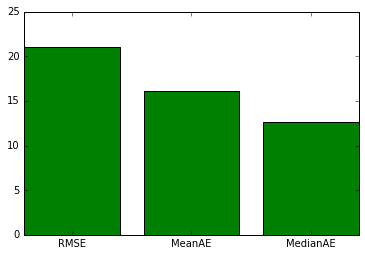

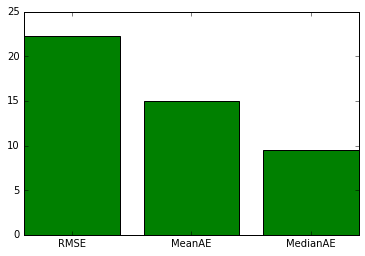

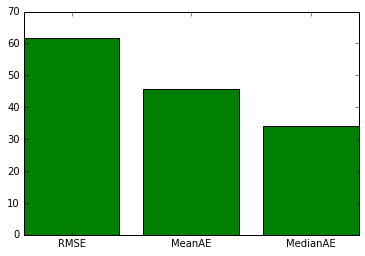

In [31]:

dfs = [private, shared, entire]

for df in dfs:
    train = {
        'RMSE':df.iloc[0]['Train RMSE'],
        'MedianAE':df.iloc[0]['Train MedianAE'],
        'MeanAE':df.iloc[0]['Train MeanAE']
    }

    test = {
        'RMSE':df.iloc[0]['Test RMSE'],
        'MedianAE':df.iloc[0]['Test MedianAE'],
        'MeanAE':df.iloc[0]['Test MeanAE']
    }

    plt.bar(range(len(train)), list(train.values()), align='center')
    plt.xticks(range(len(train)), list(train.keys()))

    plt.bar(range(len(test)), list(test.values()), align='center', color='green')
    plt.xticks(range(len(test)), list(test.keys()))
    # plt.ylim(0, 0.3)
    plt.show()


####################### TRAINING SET #######################


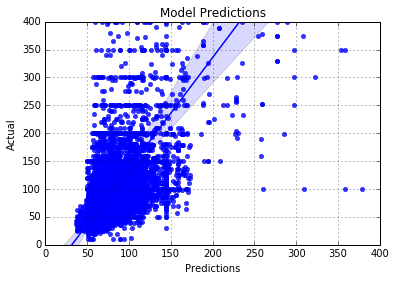

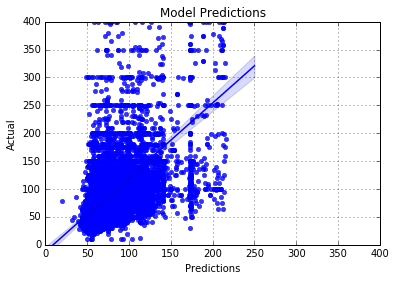

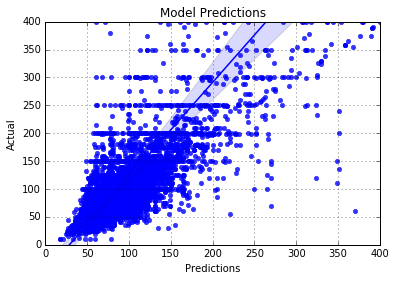

####################### TESTING SET #######################


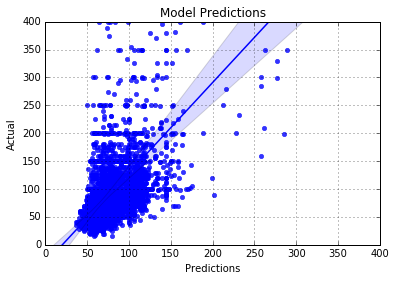

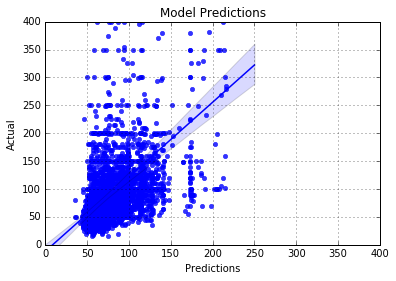

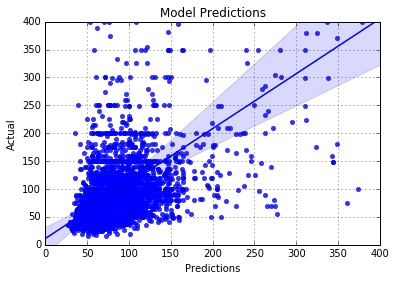

In [32]:
name = 'private'
train_preds = train_predictions[name]
test_preds = test_predictions[name]
X_train = sets[name]['X_train']
X_test = sets[name]['X_test']
y_train = sets[name]['y_train']
y_test = sets[name]['y_test']
xlim = 400
ylim = 400
print('####################### TRAINING SET #######################')
for i in range(len(train_preds)):
    
    y_pred_inv = [np.expm1(x) for x in train_preds[i]]
    y_train_inv = [np.expm1(x) for x in y_train]

#     plt.figure(figsize=(16,8))
    sb.regplot(y_pred_inv, y_train_inv)
    plt.ylabel('Actual')
    plt.xlabel('Predictions')
    plt.title("Model Predictions")
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.grid(True)
    plt.show()

print('####################### TESTING SET #######################')

for i in range(len(test_preds)):
    
    y_pred_inv = [np.expm1(x) for x in test_preds[i]]
    y_test_inv = [np.expm1(x) for x in y_test]

#     plt.figure(figsize=(16,8))
    sb.regplot(y_pred_inv, y_test_inv)
    plt.ylabel('Actual')
    plt.xlabel('Predictions')
    plt.title("Model Predictions")
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.grid(True)
    plt.show()